In [1]:
import matplotlib.pyplot as plt
import cv2

In [2]:
model = cv2.dnn.readNetFromTensorflow("graph_opt.pb")

In [3]:
BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
               "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
               "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
               "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
               ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
               ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
               ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
               ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]

In [4]:
inWidth = 368
inHeight = 368
thr = 0.2

In [5]:
def pose_estimation(image):
    
    model.setInput(cv2.dnn.blobFromImage(image, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = model.forward()
    out = out[:, :19, :, :]
    assert(len(BODY_PARTS) == out.shape[1])

    h = image.shape[0]
    w = image.shape[1]
    points = []
    
    for i in range(len(BODY_PARTS)):
        
        heatMap = out[0, i, :, :]

        _, conf, _, point = cv2.minMaxLoc(heatMap)
        x = (w * point[0]) / out.shape[3]
        y = (h * point[1]) / out.shape[2]
        
        points.append((int(x), int(y)) if conf > thr else None)

    for pair in POSE_PAIRS:
        
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            
            cv2.line(image, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv2.ellipse(image, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv2.FILLED)
            cv2.ellipse(image, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv2.FILLED)

    t, _ = model.getPerfProfile()
    freq = cv2.getTickFrequency() / 1000
    cv2.putText(image, '%.2fms' % (t / freq), (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

    return image

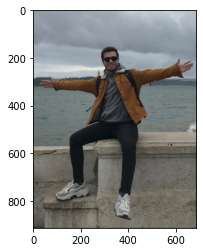

In [6]:
img = cv2.imread("6.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

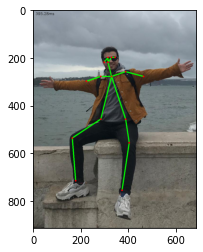

In [7]:
x = pose_estimation(img)
plt.imshow(cv2.cvtColor(x, cv2.COLOR_BGR2RGB))

In [8]:
def real_time_pose_estimation():
    
    cap = cv2.VideoCapture(1)
    cap.set(cv2.CAP_PROP_FPS, 10)
    cap.set(3, 1920)
    cap.set(4, 1080)

    if not cap.isOpened():
        cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        raise IOError("Cannot open CAM")
    
    while cv2.waitKey(1) < 0:
        hasImage, image = cap.read()
        if not hasImage:
            cv2.waitKey()
            break
            
        result = pose_estimation(image)
    
        cv2.imshow('trAI Pose Estimation CAM', result)

In [ ]:
real_time_pose_estimation()